<a href="https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/tf2/embeddings-retrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Robst Retraining of Airline Embeddings

_Keeping existing embeddings as stable as possible when chaning the model or adding new data_

In [0]:
!pip install -q tf-nightly-gpu-2.0-preview

In [19]:
import tensorflow as tf
print(tf.__version__)

2.0.0-dev20190510


## Step I: Preparing data

In [20]:
!curl -O https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2321k  100 2321k    0     0  3237k      0 --:--:-- --:--:-- --:--:-- 3237k


In [0]:
import pandas as pd

df = pd.read_csv('routes.dat', quotechar="'", sep=',', encoding='utf-8', header=None, na_values='\\N',
                names=['Airline', 'Airline ID', 'Source airport', 'Source airport ID', 'Destination airport', 'Destination airport ID', 'Codeshare', 'Stops', 'Equipment'])

# https://openflights.org/data.html#route
  
# Airline	2-letter (IATA) or 3-letter (ICAO) code of the airline.
# Airline ID	Unique OpenFlights identifier for airline (see Airline).
# Source airport	3-letter (IATA) or 4-letter (ICAO) code of the source airport.
# Source airport ID	Unique OpenFlights identifier for source airport (see Airport)
# Destination airport	3-letter (IATA) or 4-letter (ICAO) code of the destination airport.
# Destination airport ID	Unique OpenFlights identifier for destination airport (see Airport)
# Codeshare	"Y" if this flight is a codeshare (that is, not operated by Airline, but another carrier), empty otherwise.
# Stops	Number of stops on this flight ("0" for direct)
# Equipment	3-letter codes for plane type(s) generally used on this flight, separated by spaces

# df[df['Stops'] == 1] gives only a dozen or so routes, so also drop it
df.drop(['Airline ID',	'Source airport ID', 'Destination airport ID', 'Codeshare', 'Equipment', 'Stops'], axis='columns', inplace=True)

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np


airline_tokenizer = Tokenizer()
airline_tokenizer.fit_on_texts(df['Airline'])

encoded_airlines = np.array(airline_tokenizer.texts_to_sequences(df['Airline'])).reshape(-1)

In [0]:
routes = df[['Source airport', 'Destination airport']].apply(lambda x: ' '.join(x), axis=1)

routes_tokenizer = Tokenizer()
routes_tokenizer.fit_on_texts(routes)
encoded_routes = np.array(routes_tokenizer.texts_to_sequences(routes))

In [0]:
from tensorflow.keras.utils import to_categorical

# sequence of airlines encoded as a unique number
X = encoded_airlines
# sequence of pair, src, dest encoded as a unique numbers
Y = to_categorical(encoded_routes)

## Step II: Using Original 1-d Model to re-create existing embeddings

In [25]:
!curl -O https://raw.githubusercontent.com/DJCordhose/ai/master/models/airline-embedding-v1.h5

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2155k  100 2155k    0     0  3522k      0 --:--:-- --:--:-- --:--:-- 3516k


In [28]:
# https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model

from tensorflow.keras.models import load_model
model = load_model('airline-embedding-v1.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1, 1)              569       
_________________________________________________________________
flatten_1 (Flatten)          (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                100       
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 2, 50)             0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 2, 50)             5050      
_________________________________________________________________
output (Dense)               (None, 2, 3426)           174726    
Total params: 180,445
Trainable params: 180,445
Non-trainable params: 0
________________________________________________

In [0]:
# https://en.wikipedia.org/wiki/List_of_airline_codes
# https://en.wikipedia.org/wiki/List_of_largest_airlines_in_North_America
# https://en.wikipedia.org/wiki/List_of_largest_airlines_in_Europe

europe_airlines = ['LH', 'BA', 'SK', 'KL', 'AF', 'FR', 'SU', 'EW', 'TP', 'BT', 'U2']
us_airlines = ['AA', 'US', 'UA', 'WN', 'DL', 'AS', 'HA']

In [0]:
samples = [airline_tokenizer.word_index[airline_code.lower()] for airline_code in europe_airlines + us_airlines]

In [0]:
embedding_layer = model.get_layer('embedding')
embedding_model = Model(inputs=model.input, outputs=embedding_layer.output)
embeddings_1d = embedding_model.predict(samples).reshape(-1)

In [0]:
original_embeddings = embedding_model.predict(X)

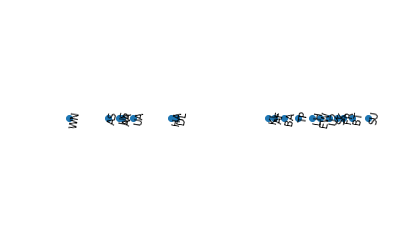

In [33]:
import matplotlib.pyplot as plt

# for printing only
# plt.figure(figsize=(20,5))
# plt.figure(dpi=600)

plt.axis('off')

plt.scatter(embeddings_1d, np.zeros(len(embeddings_1d)))
for index, x_pos in zip(samples, embeddings_1d):
  name = airline_tokenizer.index_word[index].upper()
  plt.annotate(name, (x_pos, 0), rotation=80)

## Step III: Convert original embedding model to functional API (as sequential will no longer be enough later)

https://keras.io/getting-started/functional-api-guide/



In [36]:
%%time

from tensorflow.keras.layers import Input, Flatten, Dense, LSTM, GRU, SimpleRNN, Embedding, RepeatVector
from tensorflow.keras.models import Model

from tensorflow.keras.initializers import glorot_normal
seed = 7

airlines = df['Airline'].unique()
output_dim = len(routes_tokenizer.word_index) + 1

input_dim = len(airlines) + 1
embedding_dim = 1

main_input = Input(shape=(1,), dtype='int32', name='main_input')

x = Embedding(name='embedding',
                    input_dim=input_dim, 
                    output_dim=embedding_dim, 
                    input_length=1,
                    embeddings_initializer=glorot_normal(seed=seed))(main_input)

x = Flatten()(x)

x = Dense(units=50, activation='relu', bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed))(x)

x = RepeatVector(2)(x)

x = SimpleRNN(units=50, return_sequences=True, bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed))(x)

main_output = Dense(units=output_dim, name='output', activation='softmax', bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed))(x)

model = Model(inputs=main_input, outputs=main_output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 1)]               0         
_________________________________________________________________
embedding (Embedding)        (None, 1, 1)              569       
_________________________________________________________________
flatten_4 (Flatten)          (None, 1)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 50)                100       
_________________________________________________________________
repeat_vector_4 (RepeatVecto (None, 2, 50)             0         
_________________________________________________________________
simple_rnn_4 (SimpleRNN)     (None, 2, 50)             5050      
_________________________________________________________________
output (Dense)               (None, 2, 3426)           1747

In [39]:
%%time

EPOCHS=20
BATCH_SIZE=10

history = model.fit(X, Y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/20
67663/67663 [==============================] - 75s 1ms/sample - loss: 6.3985 - accuracy: 0.0224
Epoch 2/20
67663/67663 [==============================] - 75s 1ms/sample - loss: 5.7587 - accuracy: 0.0396
Epoch 3/20
67663/67663 [==============================] - 74s 1ms/sample - loss: 5.4980 - accuracy: 0.0529
Epoch 4/20
67663/67663 [==============================] - 74s 1ms/sample - loss: 5.3415 - accuracy: 0.0601
Epoch 5/20
67663/67663 [==============================] - 74s 1ms/sample - loss: 5.2412 - accuracy: 0.0655
Epoch 6/20
67663/67663 [==============================] - 74s 1ms/sample - loss: 5.1743 - accuracy: 0.0686
Epoch 7/20
67663/67663 [==============================] - 74s 1ms/sample - loss: 5.1220 - accuracy: 0.0708
Epoch 8/20
67663/67663 [==============================] - 74s 1ms/sample - loss: 5.0822 - accuracy: 0.0727
Epoch 9/20
67663/67663 [==============================] - 74s 1ms/sample - loss: 5.0462 - accuracy: 0.0741
Epoch 10/20
67663/67663 [============

In [0]:
# we expect this to be substantially worse than the 2d version as the bottle neck now is much more narrow
loss, accuracy = model.evaluate(X, Y, batch_size=BATCH_SIZE)
loss, accuracy

In [0]:
# plt.yscale('log')
plt.plot(history.history['loss'])

In [0]:
# plt.yscale('log')
plt.plot(history.history['accuracy'])

In [0]:
import numpy as np

embedding_layer = model.get_layer('embedding')
embedding_model = Model(inputs=model.input, outputs=embedding_layer.output)
embeddings_1d = embedding_model.predict(samples).reshape(-1)

# for printing only
# plt.figure(figsize=(20,5))
# plt.figure(dpi=600)

plt.axis('off')

plt.scatter(embeddings_1d, np.zeros(len(embeddings_1d)))
for index, x_pos in zip(samples, embeddings_1d):
  name = airline_tokenizer.index_word[index].upper()
  plt.annotate(name, (x_pos, 0), rotation=80)

## Step IV: Handle Model Change

In [48]:
%%time

from tensorflow.keras.layers import Input, Flatten, Dense, LSTM, GRU, SimpleRNN, Embedding, RepeatVector
from tensorflow.keras.models import Model

from tensorflow.keras.initializers import glorot_normal
seed = 7

airlines = df['Airline'].unique()
output_dim = len(routes_tokenizer.word_index) + 1

input_dim = len(airlines) + 1
embedding_dim = 1

main_input = Input(shape=(1,), dtype='int32', name='main_input')

x = Embedding(name='embedding',
                    input_dim=input_dim, 
                    output_dim=embedding_dim, 
                    input_length=1,
                    embeddings_initializer=glorot_normal(seed=seed))(main_input)

embedding = x # just the latent space as output

x = Flatten()(x)

x = Dense(units=50, activation='relu', bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed))(x)
# second dense layer
x = Dense(units=50, activation='relu', bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed))(x)

x = RepeatVector(2)(x)

# less units
x = SimpleRNN(units=25, return_sequences=True, bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed))(x)

main_output = Dense(units=output_dim, name='main_output', activation='softmax', bias_initializer='zeros', kernel_initializer=glorot_normal(seed=seed))(x)

model = Model(inputs=main_input, outputs=[main_output, embedding])

model.compile(optimizer='adam', 
              loss={'main_output': 'categorical_crossentropy', 'embedding': 'mae' },
              loss_weights={'main_output': .1, 'embedding': 1.})

model.summary()

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
main_input (InputLayer)      [(None, 1)]               0         
_________________________________________________________________
embedding (Embedding)        (None, 1, 1)              569       
_________________________________________________________________
flatten_10 (Flatten)         (None, 1)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 50)                100       
_________________________________________________________________
dense_11 (Dense)             (None, 50)                2550      
_________________________________________________________________
repeat_vector_10 (RepeatVect (None, 2, 50)             0         
_________________________________________________________________
simple_rnn_10 (SimpleRNN)    (None, 2, 25)             1900

In [49]:
%%time

EPOCHS=20
BATCH_SIZE=10

history = model.fit(x=X, 
                    y={'main_output': Y, 'embedding': original_embeddings},
                    epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)

Epoch 1/20
15320/67663 [=====>........................] - ETA: 1:14 - loss: 7.5179 - main_output_loss: 6.8783 - embedding_loss: 0.6395

KeyboardInterrupt: ignored

In [0]:
embedding_layer = model.get_layer('embedding')
embedding_model = Model(inputs=model.input, outputs=embedding_layer.output)
embeddings_1d = embedding_model.predict(samples).reshape(-1)

# for printing only
# plt.figure(figsize=(20,5))
# plt.figure(dpi=600)

plt.axis('off')

plt.scatter(embeddings_1d, np.zeros(len(embeddings_1d)))
for index, x_pos in zip(samples, embeddings_1d):
  name = airline_tokenizer.index_word[index].upper()
  plt.annotate(name, (x_pos, 0), rotation=80)

## Clustering in 2d

1d embedding vs size of airline
* find what is similar
* what is an outlier

In [0]:
# https://en.wikipedia.org/wiki/List_of_airline_codes
# https://en.wikipedia.org/wiki/List_of_largest_airlines_in_North_America
# https://www.tvlon.com/resources/airlinecodes.htm
# https://en.wikipedia.org/wiki/List_of_largest_airlines_in_Europe

airline_size = {
    'LH': 130, 'BA': 105, 'SK': 30, 'KL': 101, 'AF': 101, 'FR': 129, 'SU': 56, 'EW': 24, 'TP': 16, 'BT': 4, 'U2': 88, 'AA': 204, 'US': 204, 'UA': 158, 'WN': 164, 'DL': 192, 'AS': 46, 'HA': 12
}
sample_names = [airline_tokenizer.index_word[sample].upper() for sample in samples]
sample_sizes = [airline_size[name] * 1e6 for name in sample_names]

In [0]:
# for printing only
# plt.figure(figsize=(20,5))
# plt.figure(dpi=600)
# plt.axis('off')

plt.scatter(embeddings_1d, sample_sizes)
for name, x_pos, y_pos in zip(sample_names, embeddings_1d, sample_sizes):
  plt.annotate(name, (x_pos,  y_pos))

In [0]:
from sklearn.preprocessing import StandardScaler

embeddings_1d_scaled = StandardScaler().fit_transform(embeddings_1d.reshape(-1, 1))
sizes_for_samples_scaled = StandardScaler().fit_transform(np.array(sample_sizes).reshape(-1, 1))
X = np.dstack((embeddings_1d_scaled.reshape(-1), sizes_for_samples_scaled.reshape(-1)))[0]
X_scaled = StandardScaler().fit_transform(X)
X_scaled

In [0]:
from sklearn.cluster import DBSCAN

clf = DBSCAN(eps=0.75, min_samples=2)
clf.fit(X_scaled)
clusters = clf.labels_.astype(np.int)
clusters

In [0]:
import matplotlib.pyplot as plt

from itertools import cycle, islice

# last color is black to properly display label -1 as noise (black)
colors = np.append(np.array(list(islice(cycle(['#AAAAFF', '#ff7f00', '#4daf4a',
                                 '#f781bf', '#a65628', '#984ea3',
                                 '#999999', '#e41a1c', '#dede00']),
                          int(max(clusters) + 1)))), ['#000000'])

# plt.figure(dpi=600)

plt.xlabel('Similarity by typical routes')
plt.ylabel('Passengers')

plt.scatter(embeddings_1d, sample_sizes, color=colors[clusters], s=200)
for name, x_pos, y_pos in zip(sample_names, embeddings_1d, sample_sizes):
  plt.annotate(name, (x_pos,  y_pos), fontsize=18, color='grey')


## Making results more stable

* when you visualize latent spaces they should not change much when re-training or fitting additional data points
* when working with autoencoders or embeddings there are two ways to make that happen
  1. save model, do not retrain from scratch and only fit new data points with low learning rate
  1. save output from embedding and keep new latent space similar by adding to the loss function

In [0]:
# save complete model
model.save('airline-embedding-v1.h5')
del model